In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



pd.options.display.max_columns = 50


In [2]:
df = pd.read_csv('../data/dataset.csv', delimiter=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

Наблюдения с пропусками в таргете стоит сразу удалить, поскольку нужно решить задачу бинарной классификации

In [4]:
df = df.dropna(subset=['default'])

In [5]:
df['default'].value_counts()

0.0    88688
1.0     1288
Name: default, dtype: int64

Количество элементов разного класса несбалансировано, нужно будет сделать `oversampling` или `undersampling`

Признак `uuid` неинформативный, удалим.

In [6]:
df = df.drop(columns=['uuid'])

В датасете много признаков с пропусками

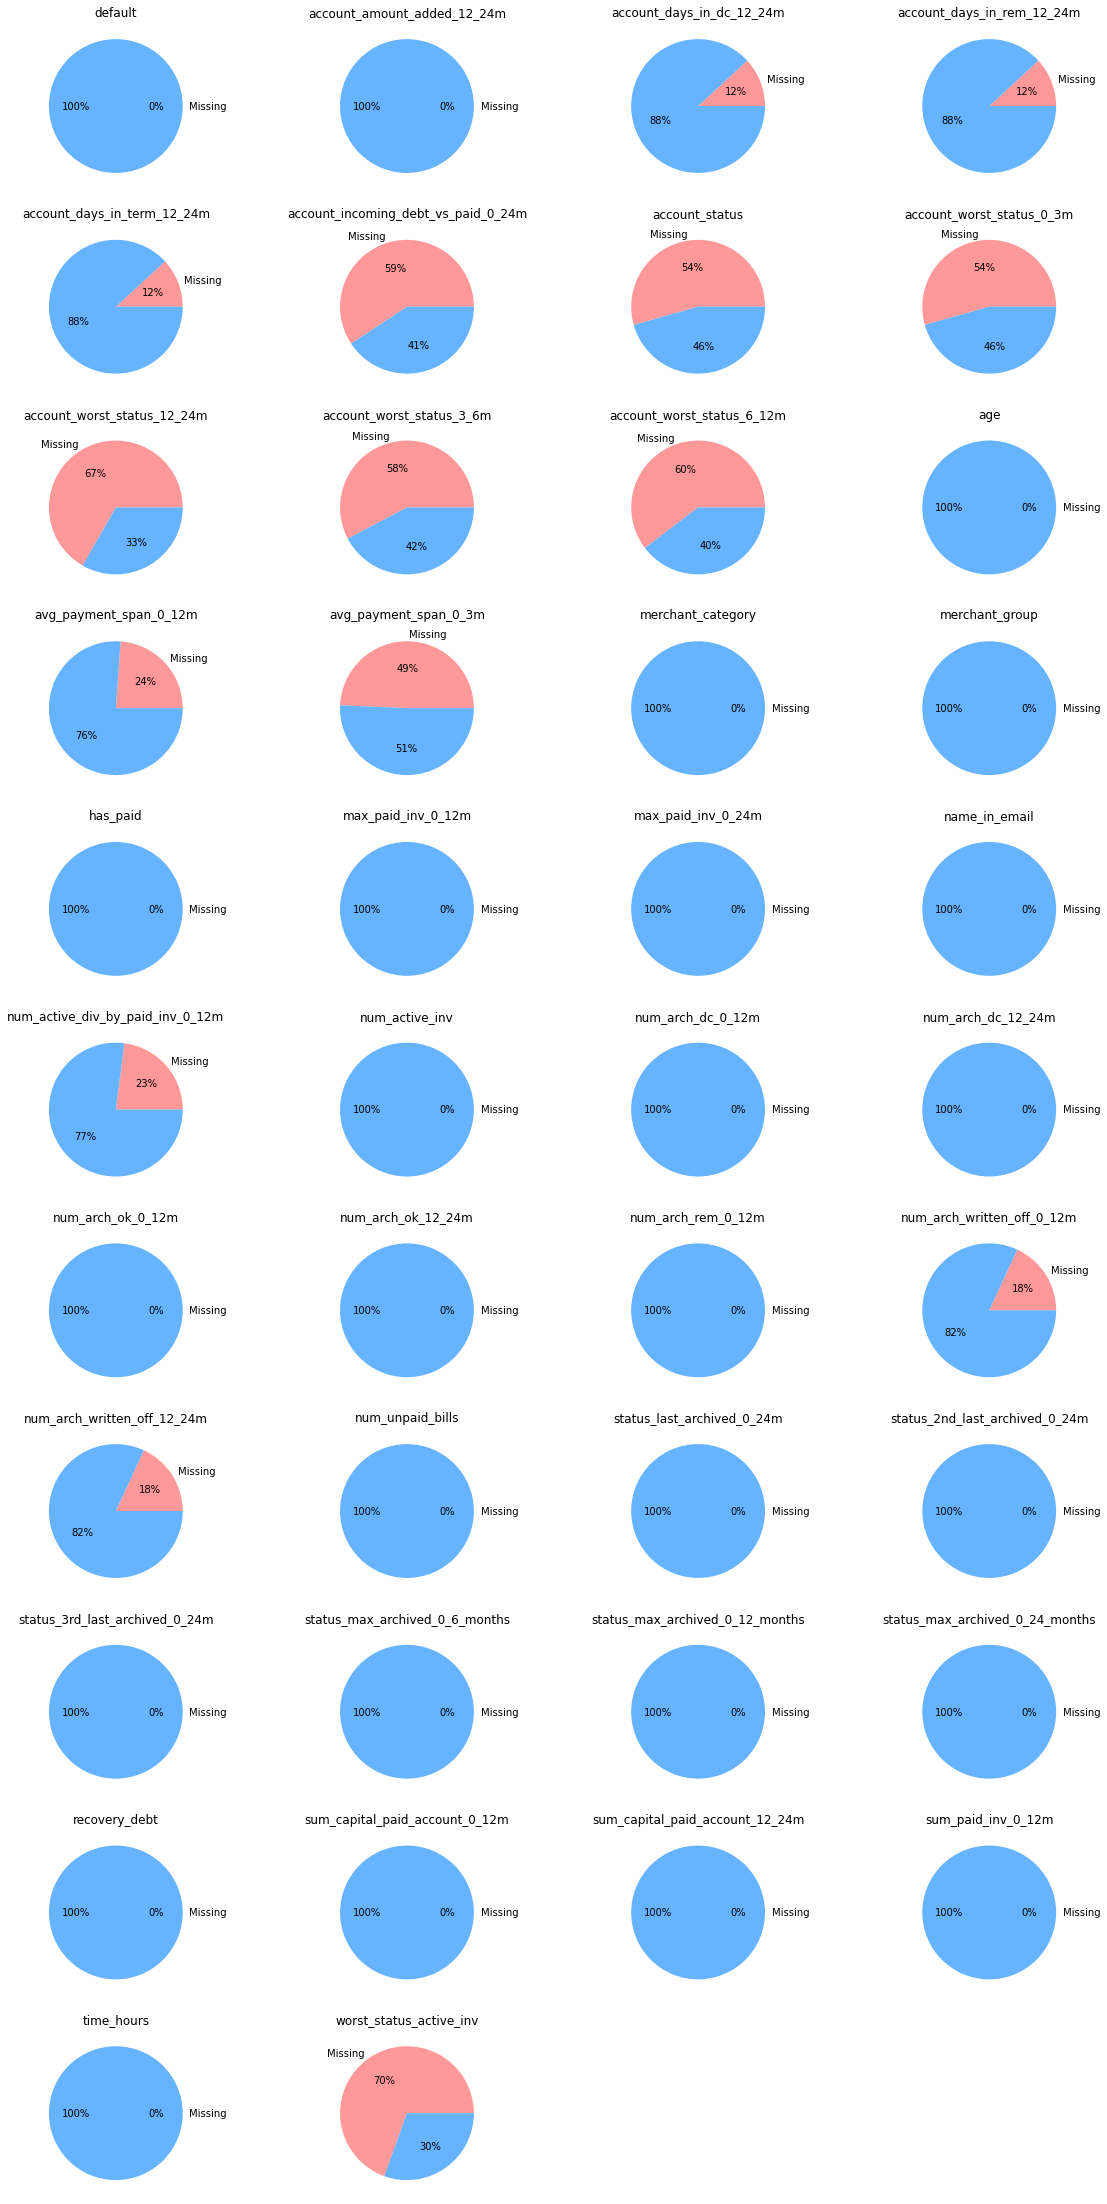

In [7]:
fig, axs = plt.subplots(11, 4, figsize=(20, 40))
fig.delaxes(axs[10][3])
fig.delaxes(axs[10][2])


axs = axs.ravel()

for idx, col in enumerate(df.columns):
    percent_missing = df[col].isna().mean()
    axs[idx].pie([percent_missing, 1 - percent_missing], labels=['Missing', ''], autopct='%1.0f%%', colors=['#ff9999','#66b3ff'])
    axs[idx].set_title(col)


Проведем анализ признаков с пропусками более 50%.

In [8]:
cols_w_many_nans = ['worst_status_active_inv', 'avg_payment_span_0_3m', 'account_worst_status_0_3m', 
                  'account_worst_status_12_24m', 'account_worst_status_3_6m', 'account_worst_status_6_12m', 
                  'account_status', 'account_incoming_debt_vs_paid_0_24m']

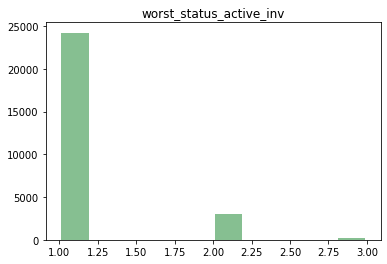

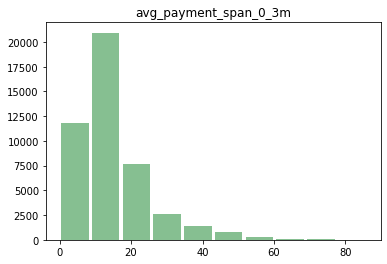

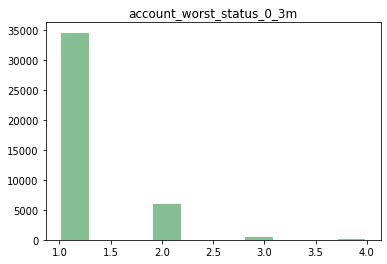

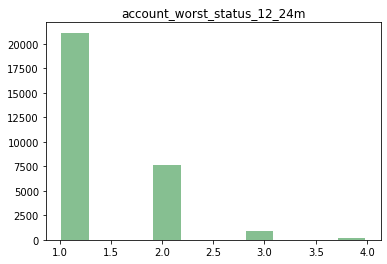

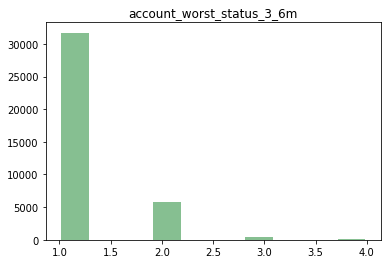

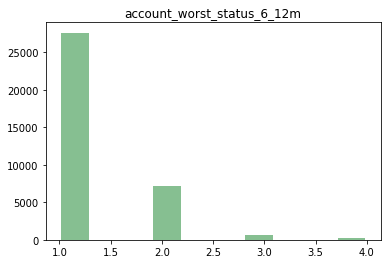

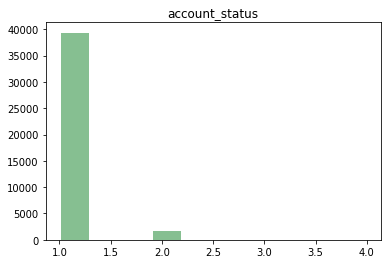

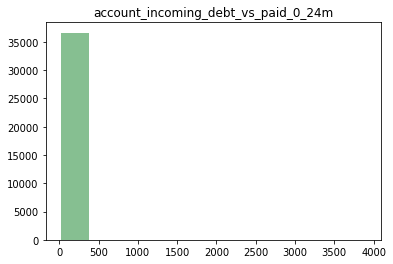

In [9]:
for col in cols_w_many_nans:
    df[col].hist(grid=False, color='#86bf91', zorder=2, rwidth=0.9)
    plt.title(col)
    plt.show()

Числовые признаки `avg_payment_span_0_3m`, `account_incoming_debt_vs_paid_0_24m` стоит сразу удалить, поскольку заполнить их какой-нибудь константой не представляется возможным без описания датасета.


Для признаков с малым количеством возможных значений `worst_status_active_inv`, `account_worst_status_0_3m`, `account_worst_status_12_24m`, `account_worst_status_3_6m`, `account_worst_status_6_12m`, `account_status` мы можем заменить пропущенные значения на константу/категорию и это может повысить итоговое качество модели, но для этого нужно понимать являются ли эти признаки числовыми/категориальными. Поэтому мы просто удалим их.

In [10]:
df = df.drop(columns=cols_w_many_nans)

Для того, чтобы избавиться от оставшихся `nan`'ов (признаки с пропусками < 50%) я предлагаю удалить наблюдения с пропущенным значениями.

In [11]:
df = df.dropna().reset_index(drop=True)

In [12]:
cat_features = ['merchant_category', 'merchant_group', 'has_paid', 'name_in_email']
num_features = list(set(df.columns) - set(cat_features))


In [13]:
df['has_paid'] = df['has_paid'].astype('int16')

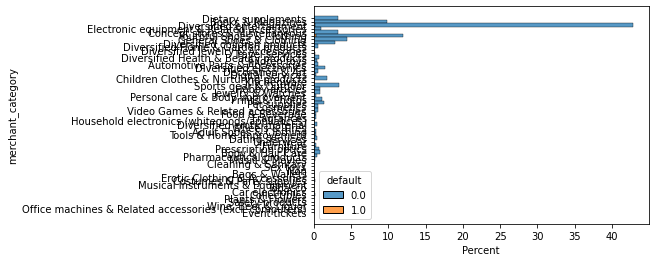

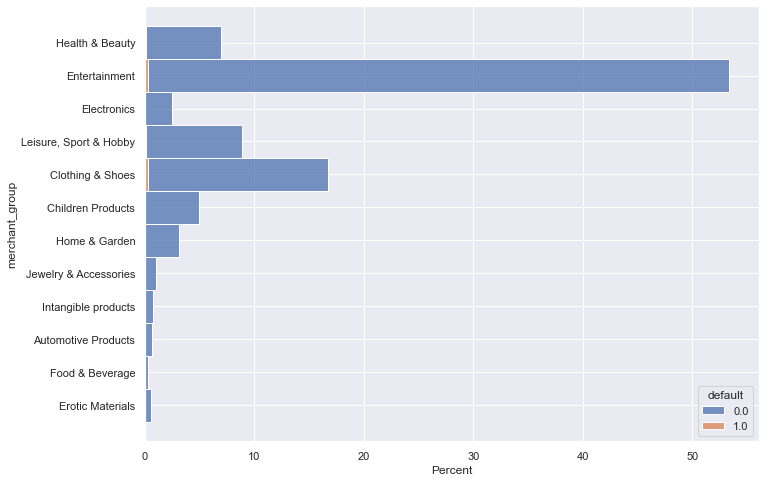

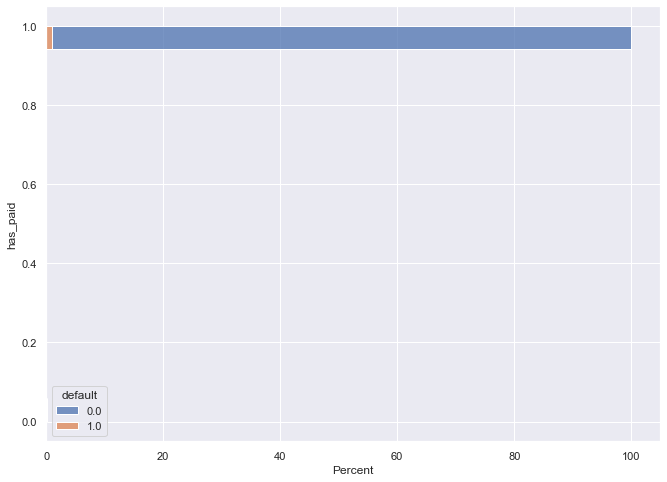

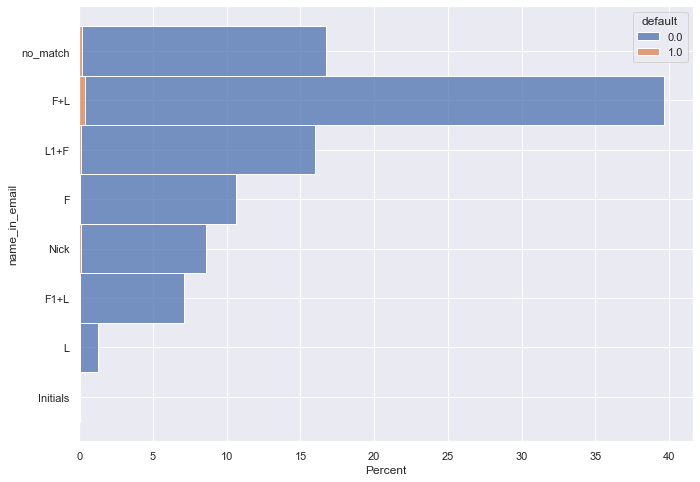

In [14]:
for cat in cat_features:
    sns.histplot(df, y=cat, hue="default", multiple="stack", stat='percent')
    plt.show()
    sns.set(rc={'figure.figsize':(11, 8)})


Для кодирования категориальных признаков `name_in_email`, `merchant_group` буду использовать `OneHotEncoder`, а для `merchant_category` воспользуюсь `FrequencyEncoder`

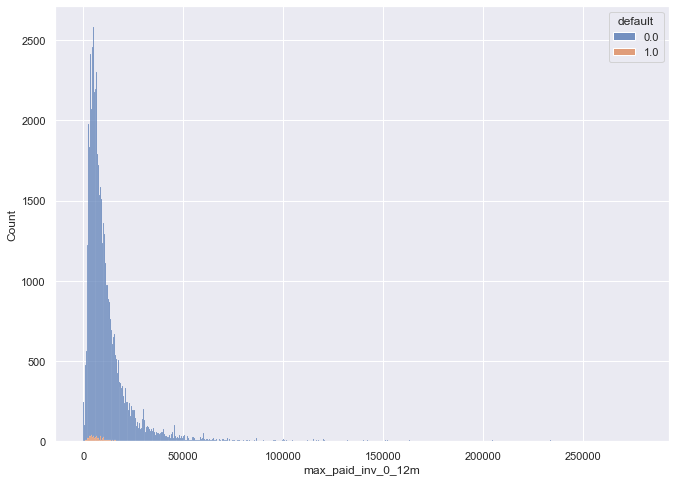

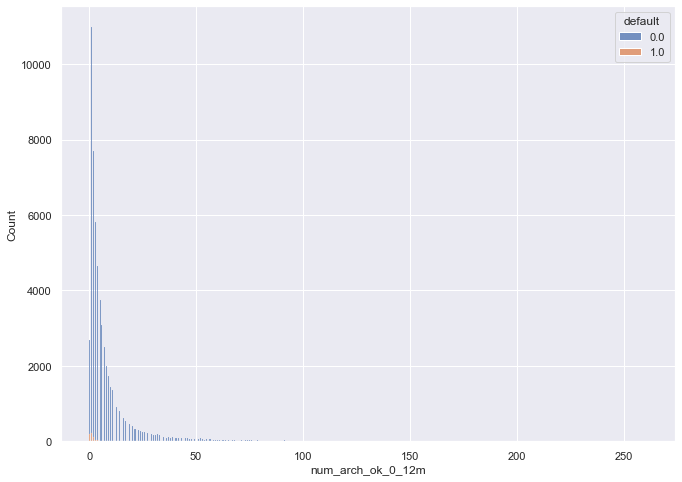

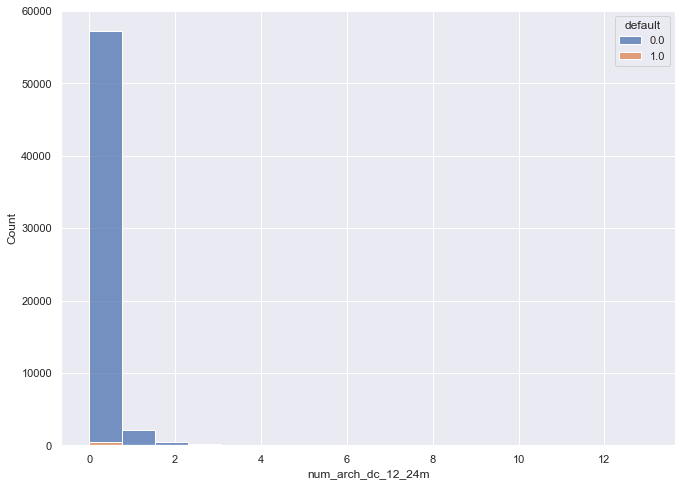

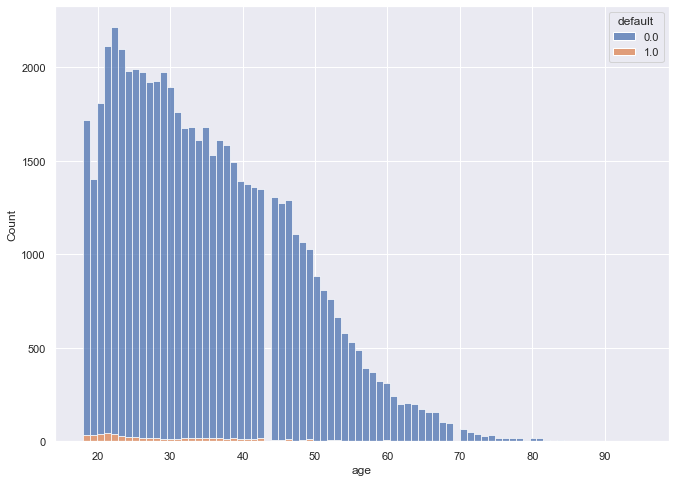

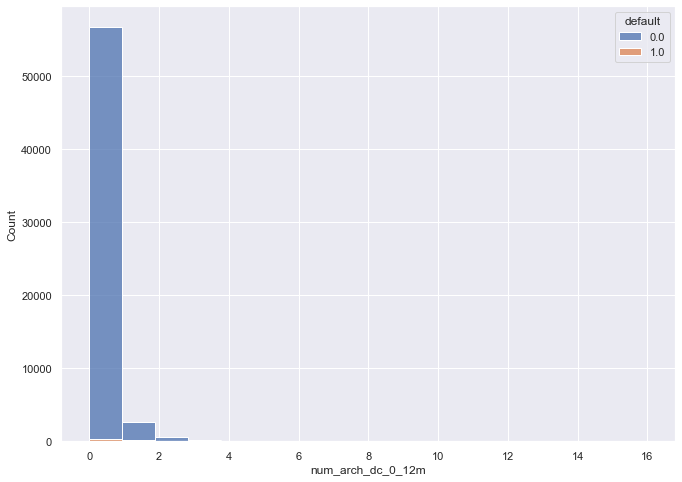

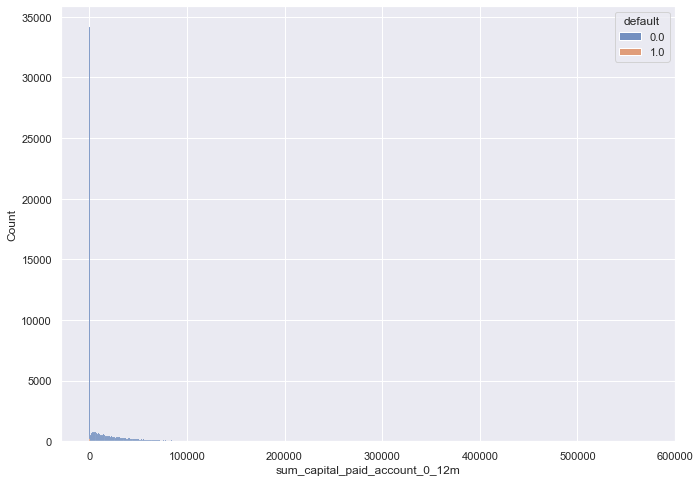

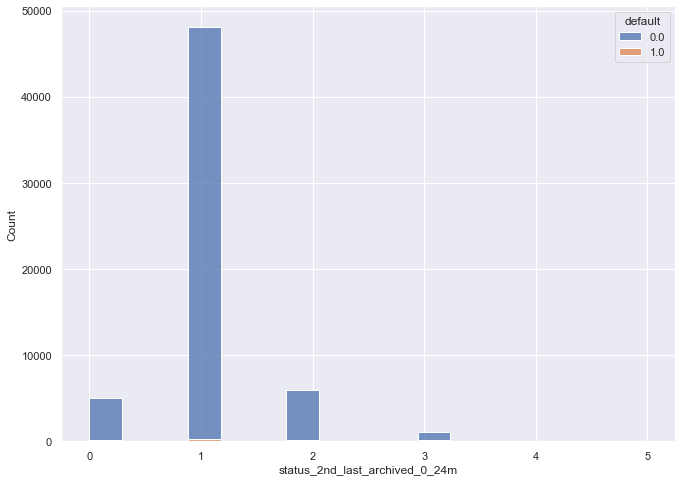

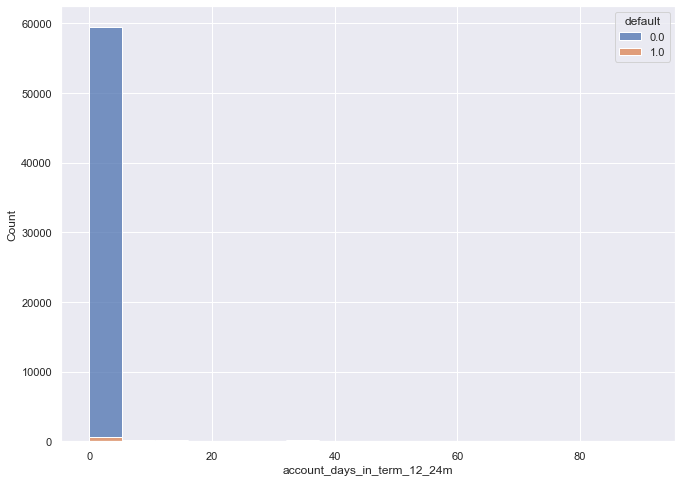

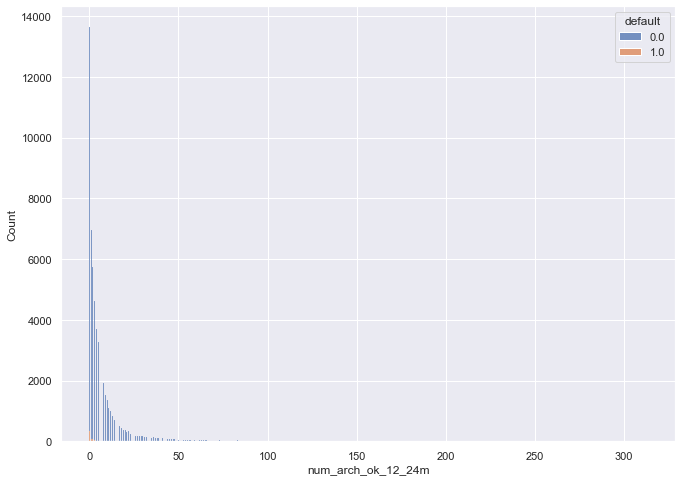

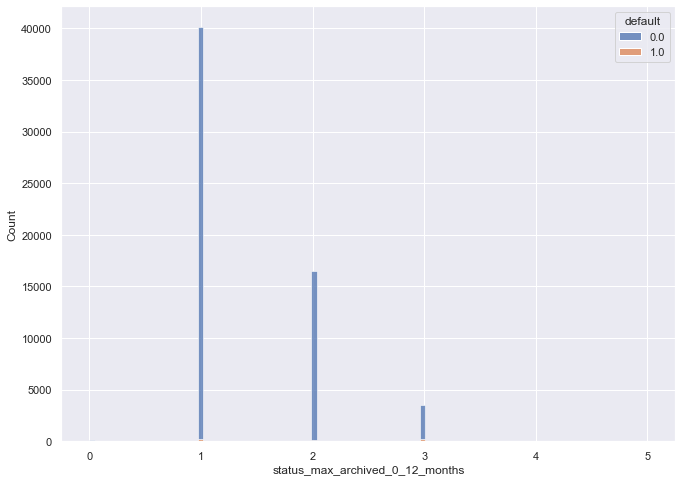

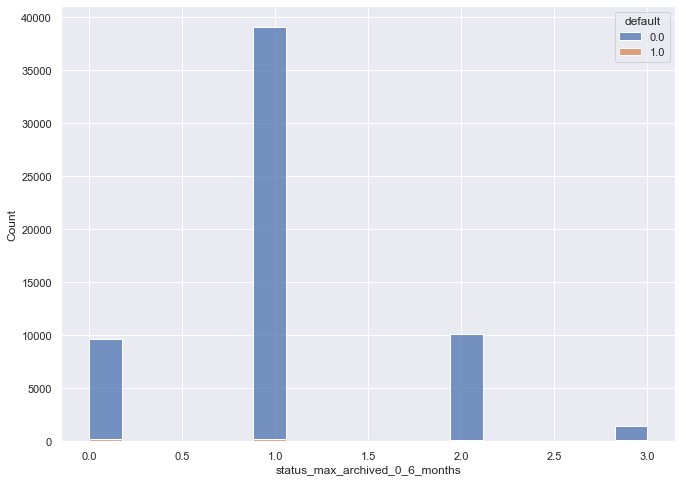

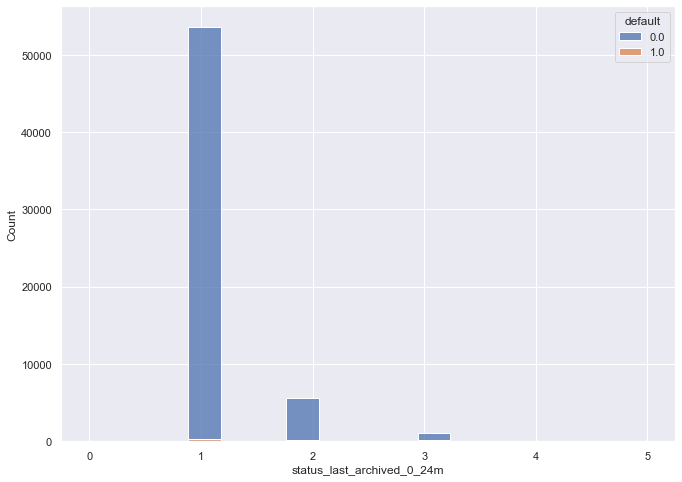

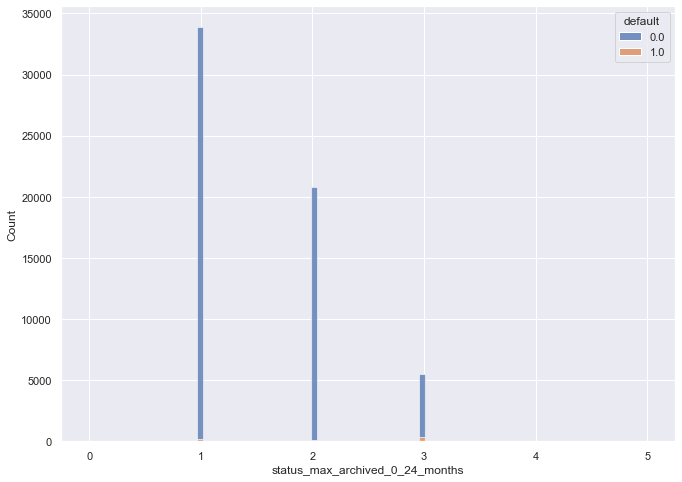

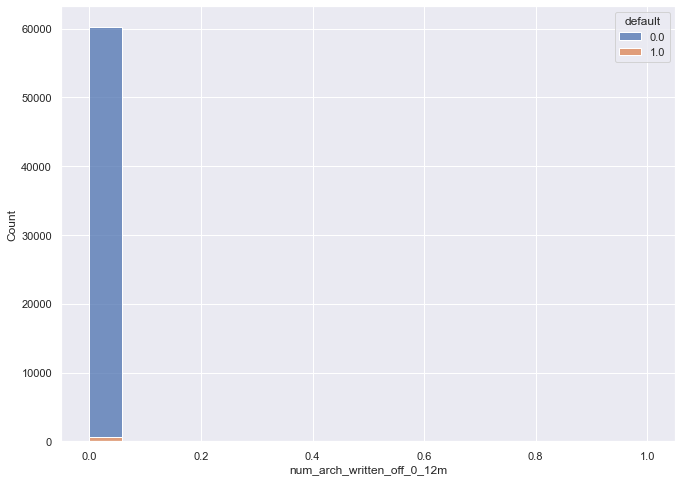

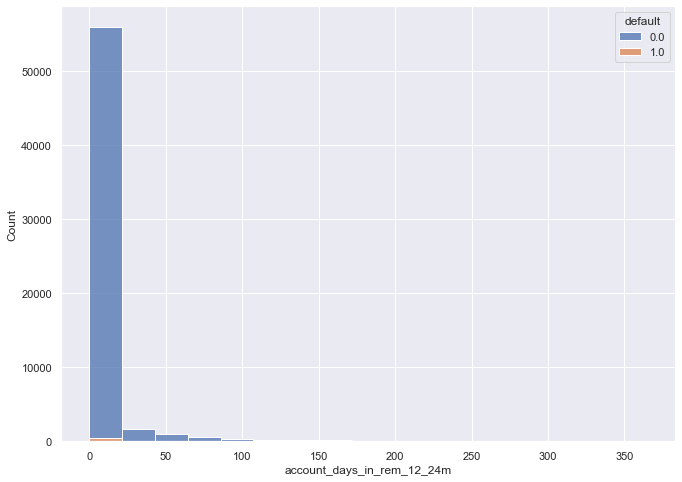

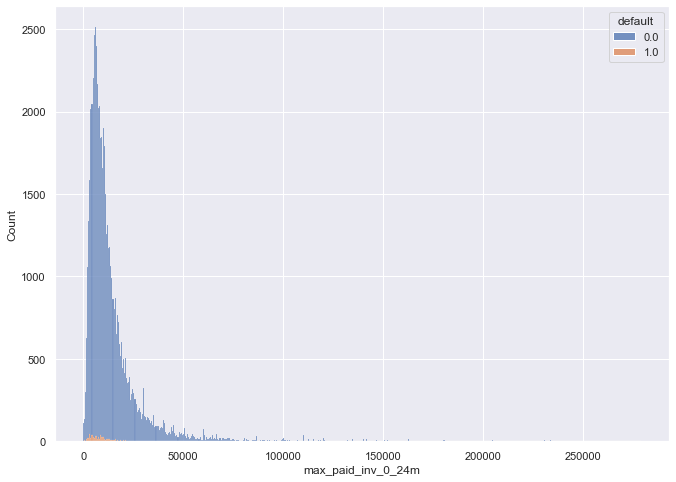

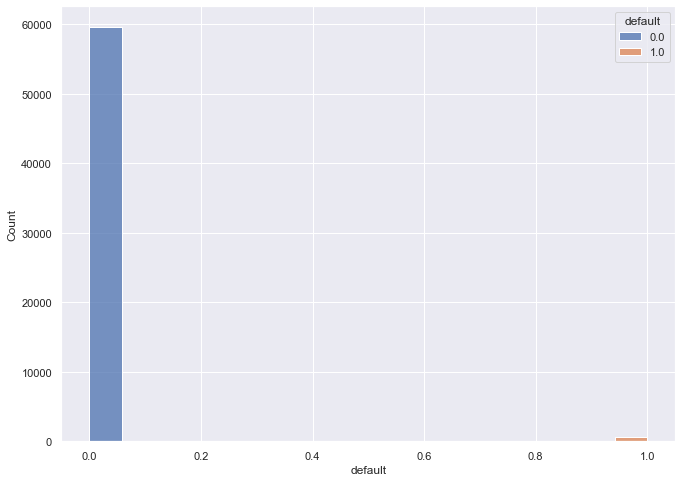

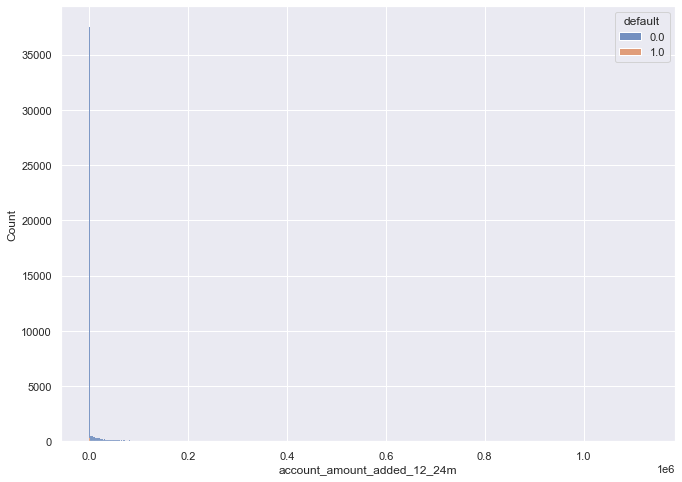

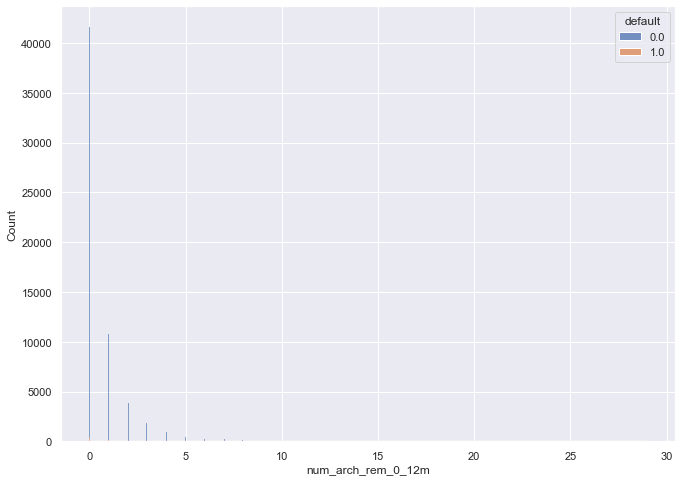

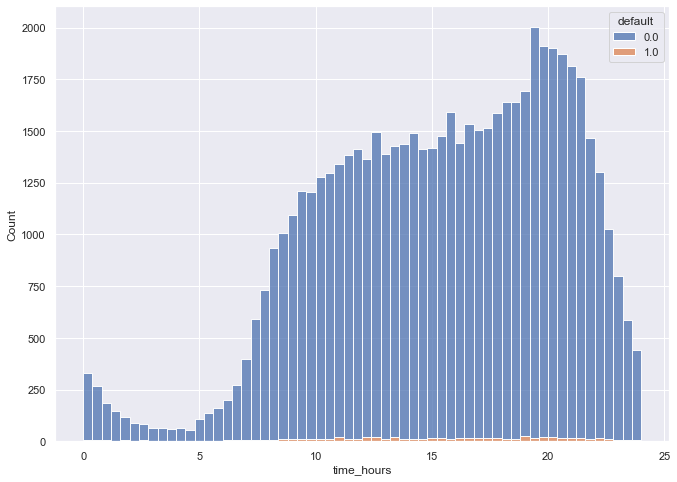

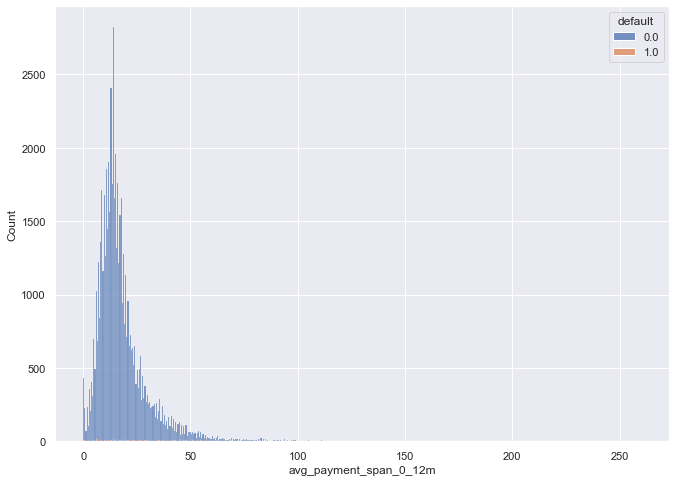

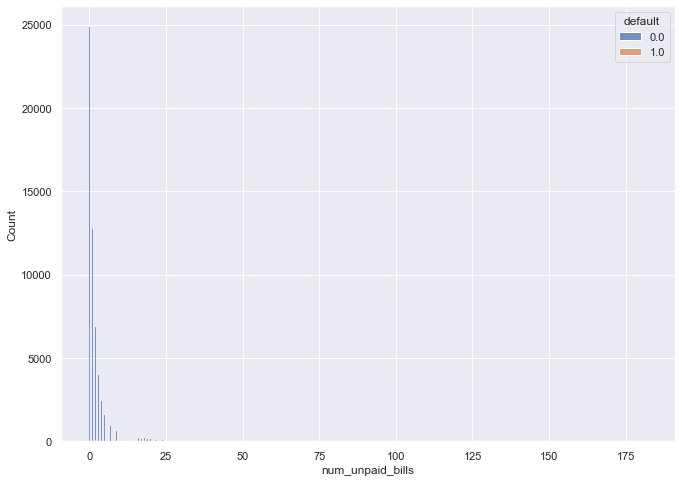

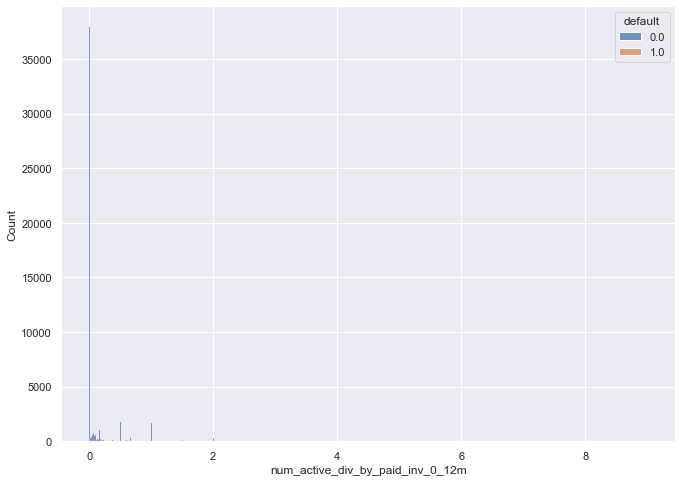

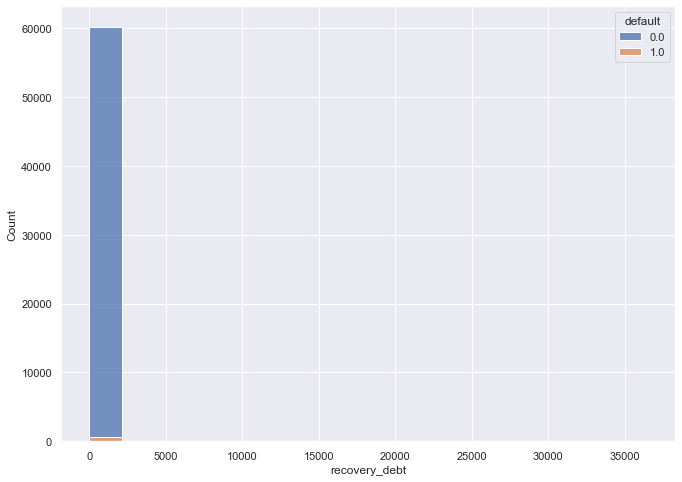

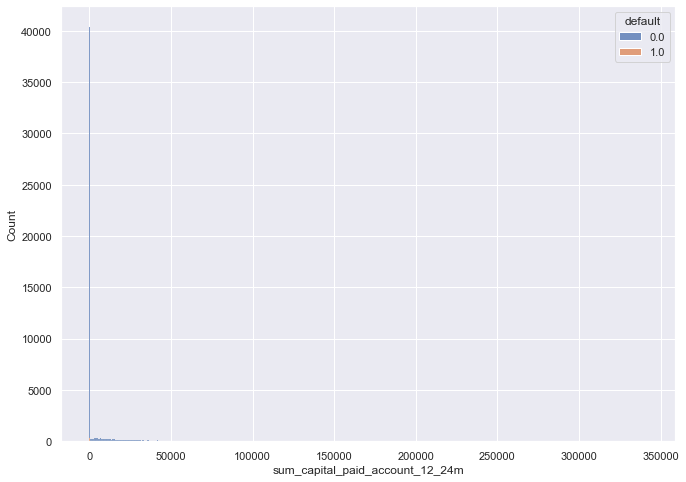

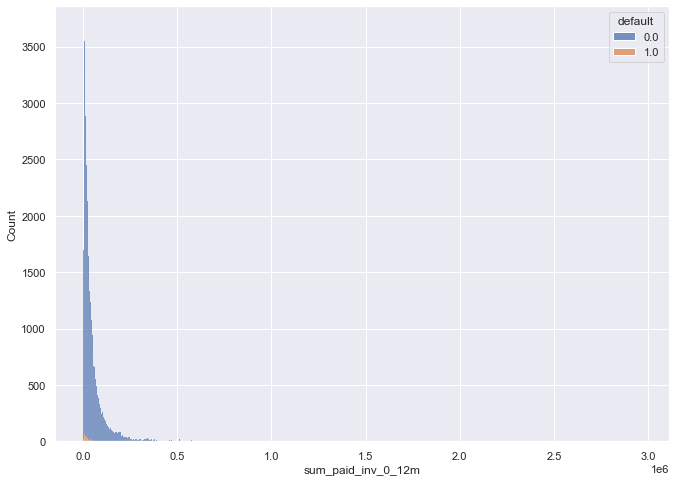

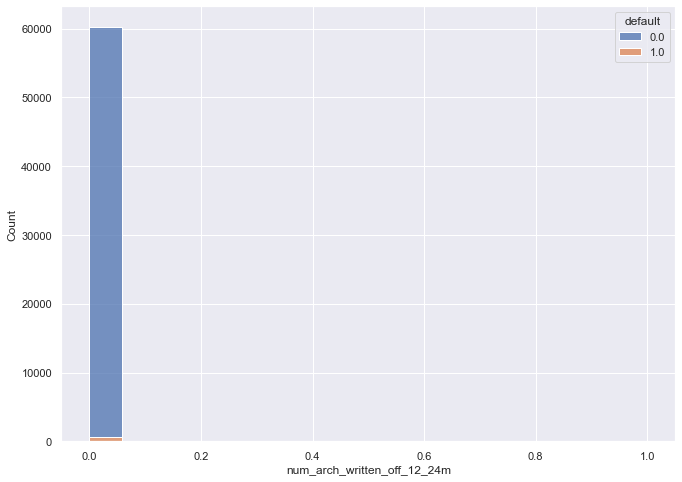

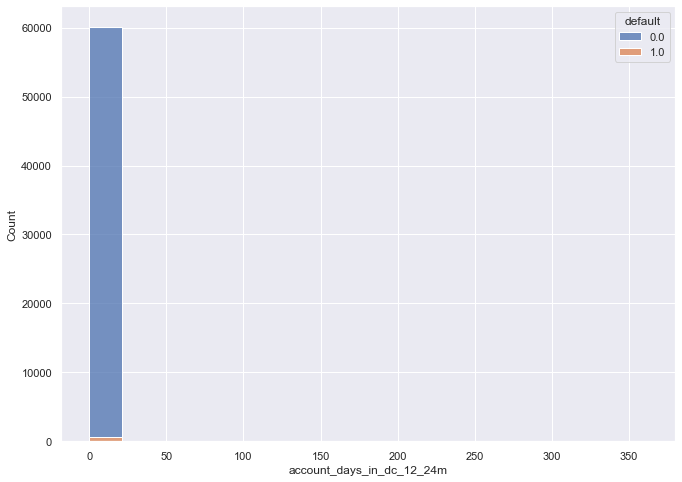

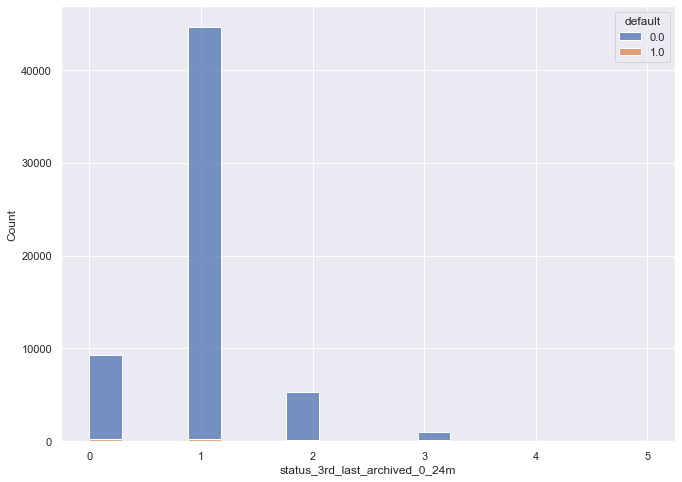

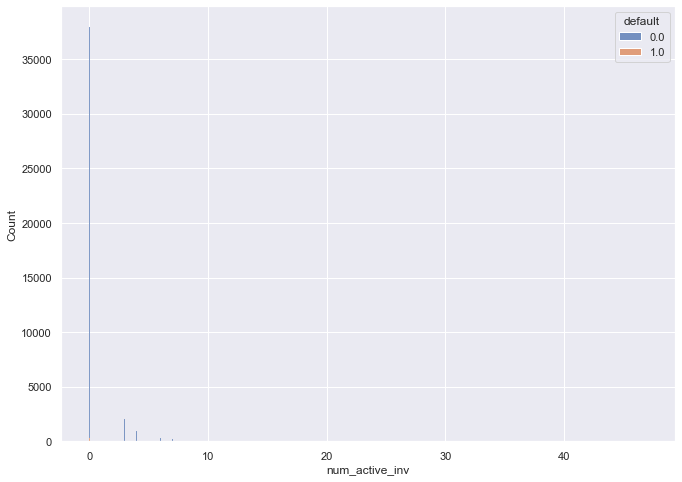

In [15]:
for cat in num_features:
    sns.histplot(df, x=cat, hue="default", multiple="stack")
    plt.show()
    sns.set(rc={'figure.figsize':(11, 8)})


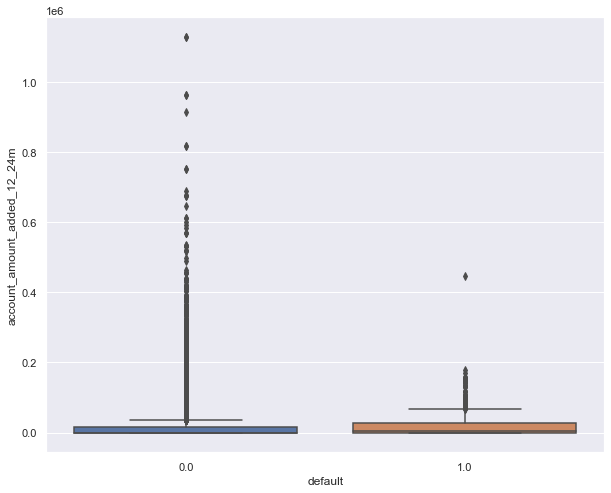

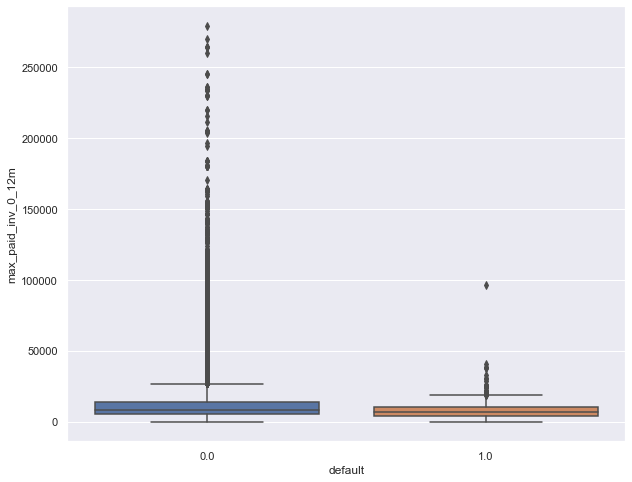

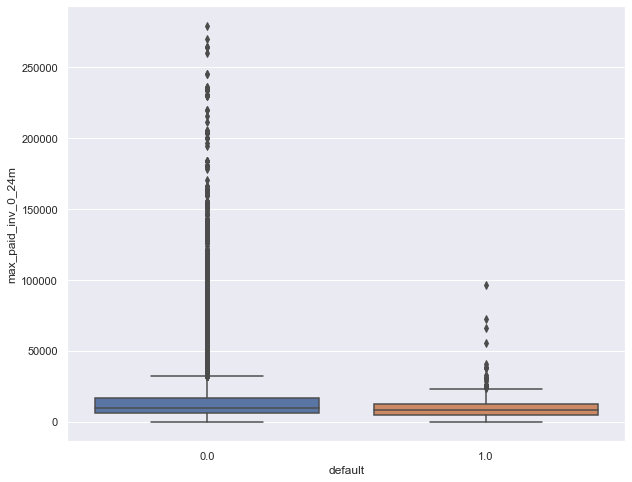

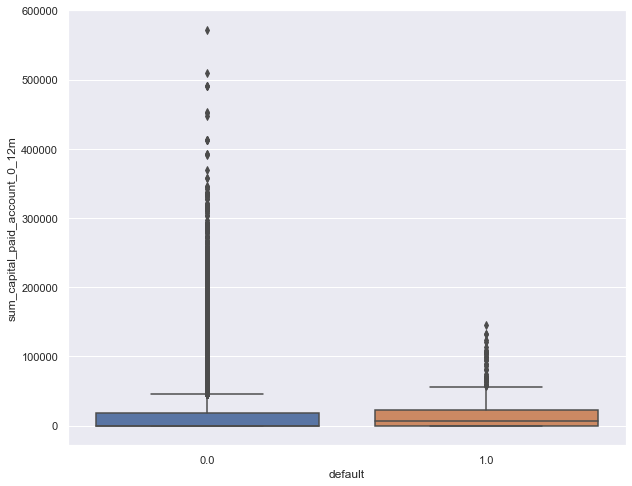

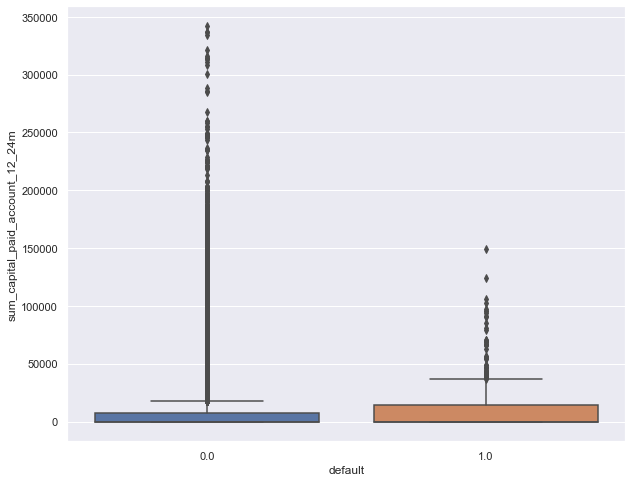

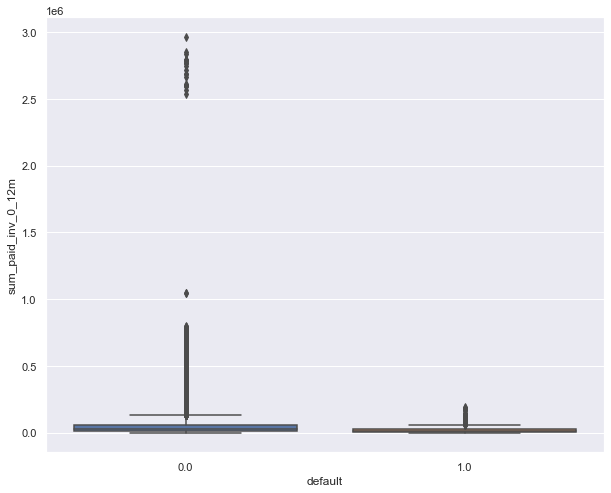

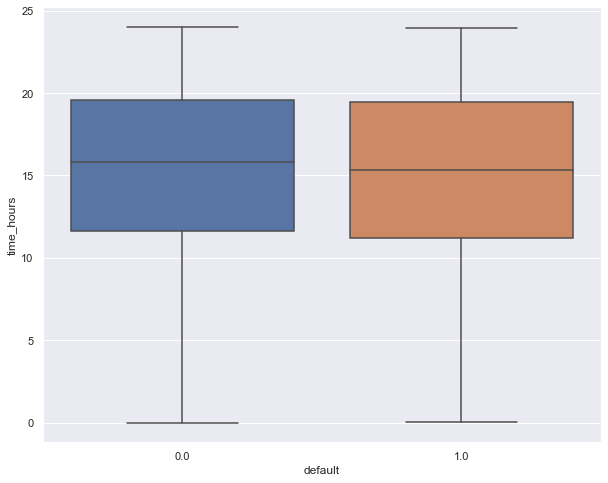

In [16]:
continuous_features = ['account_amount_added_12_24m', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'sum_capital_paid_account_0_12m'
              ,'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 'time_hours']

for col in continuous_features:
    f, ax = plt.subplots(figsize=(10, 8))
    fig = sns.boxplot(x=df['default'], y=df[col])
    plt.show()




<AxesSubplot:>

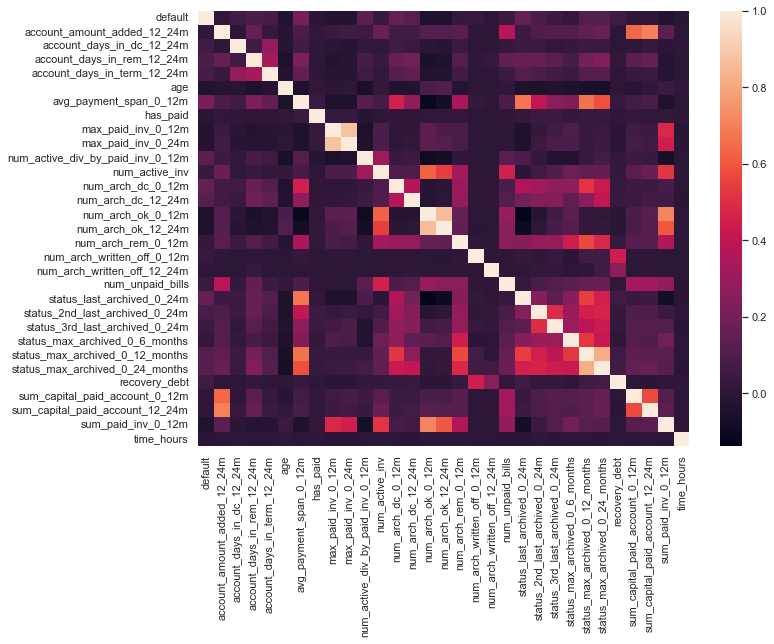

In [21]:
sns.heatmap(df.corr())

Есть сильно скореллированные пары признаков. Удалим по одному из признаков в каждой паре.


In [25]:
cols_for_del = ['status_max_archived_0_24_months', 'num_arch_ok_12_24m', 'max_paid_inv_0_24m']
df = df.drop(columns=cols_for_del)